IMPROTING NECESSARY LIBRARIES

In [1]:
import pandas as pd
import yfinance as yf 
import datetime

FETCHING/LOADING 'AAPL' unstructured data

In [2]:
data0 = pd.read_json("AAPL.json")
df = pd.DataFrame(data0)
df.head()

FileNotFoundError: File AAPL.json does not exist

IMPORTING structured data from yahoo finance

In [3]:
start = datetime.datetime(2024, 1, 1)
end = datetime.datetime(2024, 11, 4)

data = yf.download('AAPL', start=start, end=end)
df2 = pd.DataFrame(data)
df2.head()


C:\Users\sheet\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-01-02,187.149994,188.440002,183.889999,185.639999,184.938217,82488700
2024-01-03,184.220001,185.880005,183.429993,184.250000,183.553482,58414500
2024-01-04,182.149994,183.089996,180.880005,181.910004,181.222321,71983600
2024-01-05,181.990005,182.759995,180.169998,181.179993,180.495087,62303300
2024-01-08,182.089996,185.600006,181.500000,185.559998,184.858521,59144500


DROP unecessary columns

In [ ]:
df2.drop(['Close', 'High', 'Low', 'Adj Close', 'Volume'], axis=1, inplace=True)
df2.head()

,Open
Date,
2024-01-02,187.149994
2024-01-03,184.220001
2024-01-04,182.149994
2024-01-05,181.990005
2024-01-08,182.089996


ADD 'trend' column

In [ ]:
def Add_Trend_Column(df):
    # Shift Close prices to compare with previous day's Close
    df['Prev_Open'] = df['Open'].shift(1)
    
    # Compute difference between today's and previous day's Close price
    df['Diff'] = df['Open'] - df['Prev_Open']
    
    # Determine Trend based on difference
    df['Trend'] = df['Diff'].apply(lambda x: 'rise' if x > 0 else 'fall' if x < 0 else 'equal')
    
    # Drop intermediate columns
    df = df.drop(columns=['Prev_Open', 'Diff'])
    
    return df
    
df2 = Add_Trend_Column(df2)
df2.head()

,Open,Trend
Date,,
2024-01-02,187.149994,equal
2024-01-03,184.220001,fall
2024-01-04,182.149994,fall
2024-01-05,181.990005,fall
2024-01-08,182.089996,rise


CLASSIFICATION MODEL- RANDOM FOREST MODEL FOR TREND PREDICTION (rise or fall or equal)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [ ]:
# Label encode 'Trend' for classification
label_encoder = LabelEncoder()
df2['Trend_encoded'] = label_encoder.fit_transform(df2['Trend'])

# Shift 'Trend_encoded' column to create next day's trend prediction
df2['Next_day_trend'] = df2['Trend_encoded'].shift(-1)
df2.dropna(inplace=True)  # Remove last row as it has no next day trend

# Define features and target
X = df2[['Open']]  # Using 'Open' as the sole feature for simplicity
y = df2['Next_day_trend']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)

# Evaluation metrics
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Retrieve the 'Open' price of the most recent day
next_day_open = df2.iloc[-1]['Open']

# Prepare the input for prediction; make sure it's a 2D array
next_day_pred = model.predict([[next_day_open]])


# Ensure we extract the first predicted value
predicted_trend_index = int(next_day_pred[0])  # Ensure it's an integer

# Convert the predicted index back to the original 'Trend' label
predicted_trend = label_encoder.inverse_transform([predicted_trend_index])

# Print the predicted trend
print("Predicted Next Day Trend:", predicted_trend[0])

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Check the shape of the confusion matrix
print("Confusion Matrix:\n", cm)

# Determine unique classes
unique_classes = np.unique(np.concatenate((y_test, y_pred)))

# Create a DataFrame for better labeling
cm_df = pd.DataFrame(cm, index=unique_classes, columns=unique_classes)

# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Draw the heatmap
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=True)

# Labels and title
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix Heatmap')

# Show the plot
plt.show()



Confusion Matrix:
 [[12 13]
 [11  7]]

Classification Report:
               precision    recall  f1-score   support

         1.0       0.52      0.48      0.50        25
         2.0       0.35      0.39      0.37        18

    accuracy                           0.44        43
   macro avg       0.44      0.43      0.43        43
weighted avg       0.45      0.44      0.44        43

Predicted Next Day Trend: fall
Confusion Matrix:
 [[12 13]
 [11  7]]


C:\Users\sheet\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


NameError: name 'np' is not defined

MERGE THE TWO DATAFRAMES

In [ ]:
df2.reset_index(inplace=True)
# Rename the 'Date' column in df2 to match the 'date' column in df1
df2.rename(columns={'Date': 'date'}, inplace=True)

In [ ]:
# Merge the two DataFrames on the 'date' column
merged_df = pd.merge(df, df2[['date', 'Open','Trend']], on='date', how='left')

# Display the merged DataFrame
merged_df.head()

,date,ticker,news,Open,Trend
0,2024-01-01,AAPL,"[{'index': 0, 'time': '06:21:00', 'title': '2 ...",NaN,NaN
1,2024-01-02,AAPL,"[{'index': 8, 'time': '00:00:00', 'title': 'AA...",187.149994,equal
2,2024-01-03,AAPL,"[{'index': 67, 'time': '00:00:00', 'title': ' ...",184.220001,fall
3,2024-01-04,AAPL,"[{'index': 86, 'time': '00:00:00', 'title': ' ...",182.149994,fall
4,2024-01-05,AAPL,"[{'index': 98, 'time': '00:00:00', 'title': '3...",181.990005,fall


In [ ]:
none_sentiment_rows = merged_df[merged_df['news'].apply(lambda x: any(news.get('sentiment') is None for news in x))]
none_sentiment_rows

,date,ticker,news,Open,Trend
24,2024-01-30,AAPL,"[{'index': 550, 'time': '00:00:00', 'title': '...",190.940002,fall


SENTIMENT ANALYSIS

In [ ]:
def calculate_average_sentiment(news_list):
    total_sentiment = {'polarity': 0, 'neg': 0, 'neu': 0, 'pos': 0}
    count = 0

    for news in news_list:
        if news is not None:
            sentiment = news.get('sentiment')  # Use get to avoid KeyError
            if sentiment:  # Check if sentiment is not None and not empty 
                total_sentiment['polarity'] += sentiment.get('polarity', 0)
                total_sentiment['neg'] += sentiment.get('neg', 0)
                total_sentiment['neu'] += sentiment.get('neu', 0)
                total_sentiment['pos'] += sentiment.get('pos', 0)
                count += 1  # Increment count only if valid sentiment exists

    # Calculate average
    if count > 0:
        average_sentiment = {k: v / count for k, v in total_sentiment.items()}
    else:
        average_sentiment = {k: 0 for k in total_sentiment}  # Default to zero if no valid entries

    return average_sentiment

# Calculate sentiment for each row in merged_df
merged_df['average_sentiment'] = merged_df['news'].apply(calculate_average_sentiment)

In [ ]:
from textblob import TextBlob

CALCULATE SENTIMENT SCORE

In [ ]:
# Step 1: Apply sentiment analysis using TextBlob
merged_df['Sentiment'] = merged_df['news'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)


# Step 2: Categorize sentiment based on polarity score
def categorize_sentiment(score):
    if score > 0:
        return "Positive"
    elif score == 0:
        return "Neutral"
    else:
        return "Negative"


# Step 1: Apply sentiment analysis to the 'news' column
merged_df['Sentiment'] = merged_df['news'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

# Step 4: Display the updated DataFrame with the new sentiment column
merged_df[['date', 'ticker', 'news', 'Open', 'Trend', 'Sentiment']]

,date,ticker,news,Open,Trend,Sentiment
0,2024-01-01,AAPL,"[{'index': 0, 'time': '06:21:00', 'title': '2 ...",NaN,NaN,0.148687
1,2024-01-02,AAPL,"[{'index': 8, 'time': '00:00:00', 'title': 'AA...",187.149994,equal,0.101290
2,2024-01-03,AAPL,"[{'index': 67, 'time': '00:00:00', 'title': ' ...",184.220001,fall,0.100158
3,2024-01-04,AAPL,"[{'index': 86, 'time': '00:00:00', 'title': ' ...",182.149994,fall,0.148572
4,2024-01-05,AAPL,"[{'index': 98, 'time': '00:00:00', 'title': '3...",181.990005,fall,0.093538
...,...,...,...,...,...,...
206,2024-02-12,AAPL,"[{'index': 3775, 'time': '00:00:00', 'title': ...",188.419998,fall,0.124940
207,2024-03-12,AAPL,"[{'index': 3790, 'time': '00:00:00', 'title': ...",173.149994,rise,0.143219
208,2024-04-12,AAPL,"[{'index': 3803, 'time': '00:00:00', 'title': ...",174.259995,rise,0.080152
209,2024-05-12,AAPL,"[{'index': 3815, 'time': '00:00:00', 'title': ...",NaN,NaN,0.131519


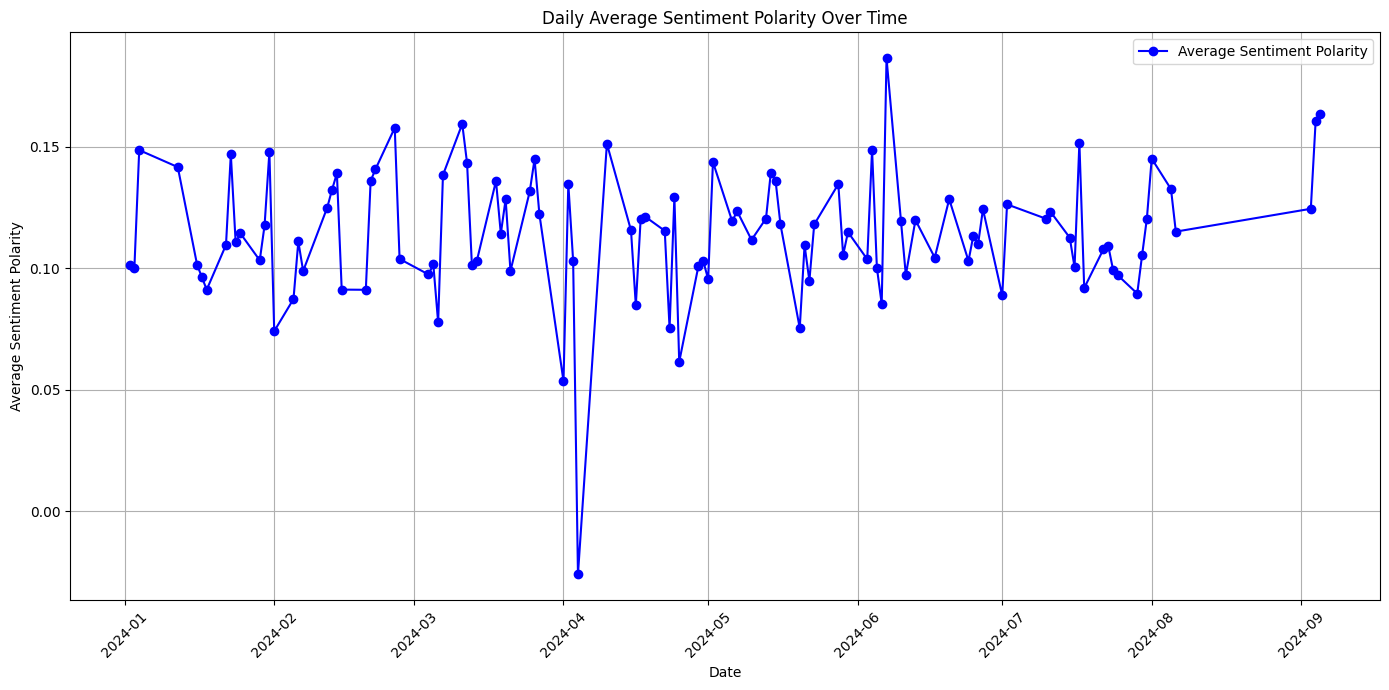

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'merged_df' has 'date', 'Sentiment' columns, and sentiment categorization is complete

# Step 1: Calculate daily average sentiment polarity
merged_df['date'] = pd.to_datetime(merged_df['date'])  # Ensure date is in datetime format
daily_sentiment = merged_df.groupby('date')['Sentiment'].mean().reset_index()

# Step 2: Plot the time series of average daily sentiment polarity
plt.figure(figsize=(14, 7))
plt.plot(daily_sentiment['date'], daily_sentiment['Sentiment'], marker='o', color='b', label='Average Sentiment Polarity')
plt.title('Daily Average Sentiment Polarity Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Polarity')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



REGRESSION MODEL-KNN MODEL FOR PRICE PREDICTION 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import numpy as np

In [ ]:
# Step 1: Apply sentiment analysis if not done already
merged_df['Sentiment'] = merged_df['news'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

# Step 2: Define the target - next day stock price (shifted 'Open' column by -1 to predict the next day's price)
merged_df['Next_Open'] = merged_df['Open'].shift(-1)

# Drop the last row with NaN in 'Next_Open'
merged_df.dropna(inplace=True)

# Step 3: Convert the Trend column to numeric using label encoding
label_encoder = LabelEncoder()
merged_df['Trend_encoded'] = label_encoder.fit_transform(merged_df['Trend'])

# Step 4: Select features and target
features = merged_df[['Open', 'Trend_encoded', 'Sentiment']]
target = merged_df['Next_Open']

# Step 5: Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Step 6: Initialize and train the KNN model
knn = KNeighborsRegressor(n_neighbors=10)
knn.fit(X_train, y_train)

# Step 7: Make predictions on the test set and calculate the error
y_pred = knn.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Step 8: Predict the next day's stock price using the most recent data
next_day_prediction = knn.predict([features.iloc[-1].values])
print(f"Predicted stock price for the next day: {next_day_prediction[0]}")

# Step 4: Create a DataFrame to compare actual and predicted values
results_df = pd.DataFrame({
    'Actual_Open': y_test,
    'Predicted_Open': y_pred
}).reset_index(drop=True)
results_df.head()


Mean Squared Error: 26.736956574653405
Predicted stock price for the next day: 172.86299896240234


C:\Users\sheet\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


,Actual_Open,Predicted_Open
0,214.690002,217.439999
1,190.940002,192.400002
2,186.089996,182.665001
3,229.449997,220.637999
4,190.979996,192.864001


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
import seaborn as sns

Mean Squared Error: 26.736956574653405
Accuracy: 98.04%


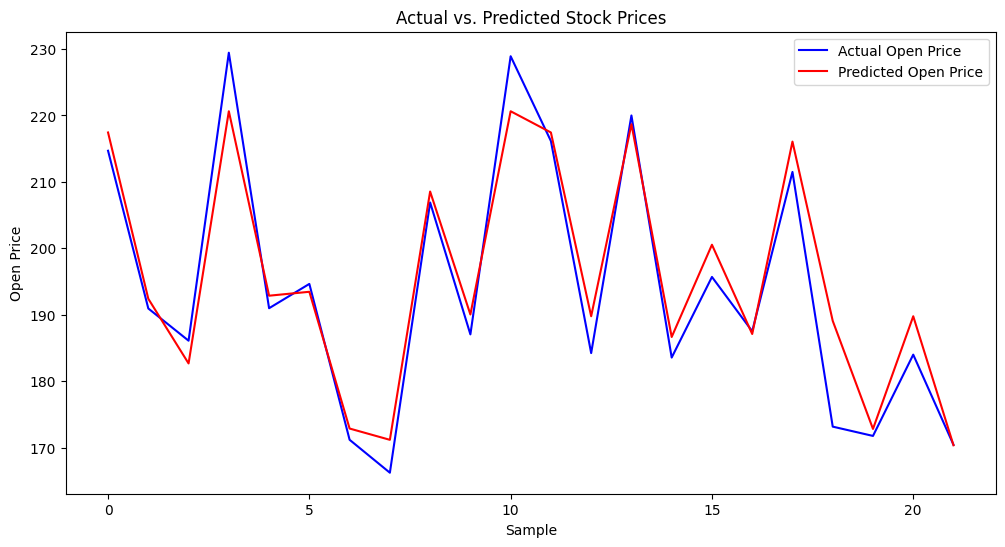

Predicted stock price for the next day: 172.86299896240234


C:\Users\sheet\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


In [ ]:
# Step 1: Calculate Mean Squared Error and Mean Absolute Percentage Error (MAPE)
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
accuracy = 100 * (1 - mape)  # Accuracy as a percentage

print(f"Mean Squared Error: {mse}")
print(f"Accuracy: {accuracy:.2f}%")

# Step 2: Plot actual vs. predicted stock prices
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual Open Price', color='blue')
plt.plot(y_pred, label='Predicted Open Price', color='red')
plt.xlabel('Sample')
plt.ylabel('Open Price')
plt.title('Actual vs. Predicted Stock Prices')
plt.legend()
plt.show()

# Step 3 Predict the next day's stock price and display it
next_day_prediction = knn.predict([features.iloc[-1].values])
print(f"Predicted stock price for the next day: {next_day_prediction[0]}")


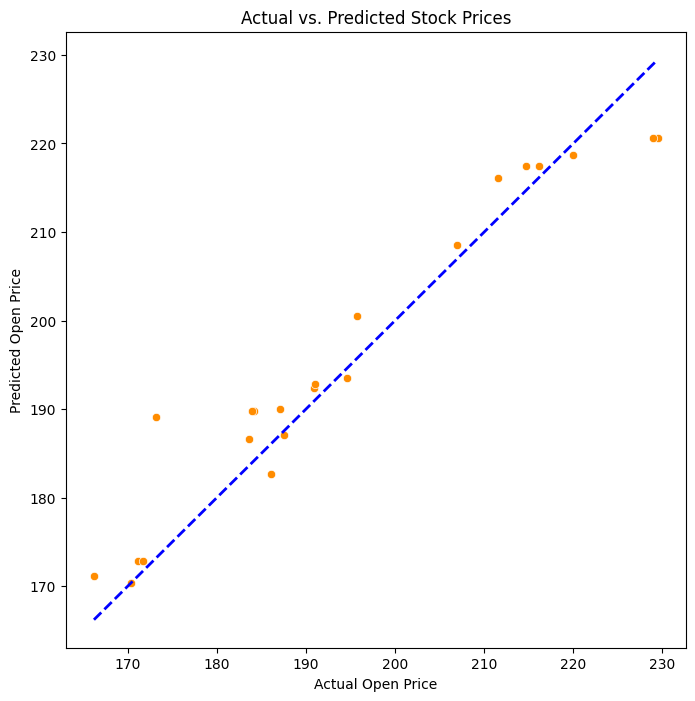

In [ ]:
# Scatter Plot of Actual vs. Predicted values
plt.figure(figsize=(8, 8))
sns.scatterplot(x=results_df['Actual_Open'], y=results_df['Predicted_Open'], color='darkorange')
plt.plot([results_df['Actual_Open'].min(), results_df['Actual_Open'].max()], 
         [results_df['Actual_Open'].min(), results_df['Actual_Open'].max()], 
         color='blue', linestyle='--', lw=2)
plt.title('Actual vs. Predicted Stock Prices')
plt.xlabel('Actual Open Price')
plt.ylabel('Predicted Open Price')
plt.show()

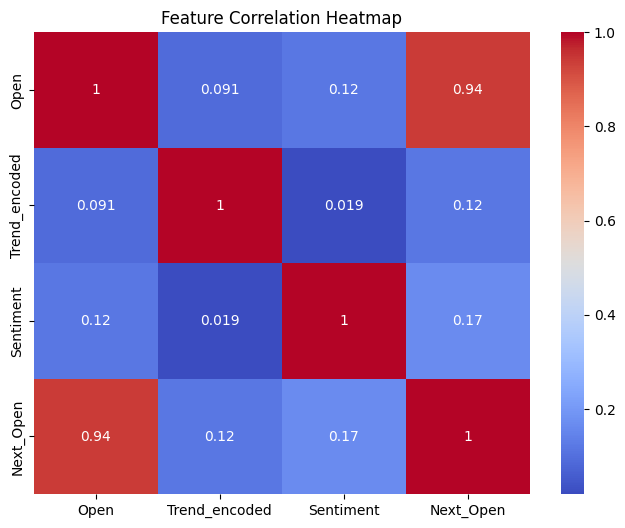

In [ ]:
# Correlation Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(merged_df[['Open', 'Trend_encoded', 'Sentiment', 'Next_Open']].corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)

# Calculate R-squared as a measure of "accuracy" in regression
accuracy = r2_score(y_test, y_pred)

# Optionally, calculate Mean Absolute Percentage Error (MAPE) for interpretability
mape = mean_absolute_percentage_error(y_test, y_pred) * 100  # Convert to percentage

# Display the performance metrics
print(f"Model Accuracy (R-squared): {accuracy:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

import pandas as pd

# Sample the first 10 rows of predicted vs. actual for the table
sample_results_df = results_df.head(10)

# Create the summary table with model metrics
summary_table = pd.DataFrame({
    'Metric': ['Model Accuracy (R-squared)', 'Mean Squared Error (MSE)', 'Mean Absolute Percentage Error (MAPE)'],
    'Value': [accuracy, mse, mape]
})

# Create the actual vs predicted price DataFrame
predicted_vs_actual = pd.DataFrame({
    'Metric': [f'Actual vs Predicted Price (Row {i+1})' for i in range(10)],
    'Value': [f"{actual} vs {pred}" for actual, pred in zip(sample_results_df['Actual_Open'], sample_results_df['Predicted_Open'])]
})

# Concatenate the metric summary table and predicted vs actual data
summary_table = pd.concat([summary_table, predicted_vs_actual], ignore_index=True)

# Display the summary table
print("Model Summary Table:")
summary_table.head(10)


Model Accuracy (R-squared): 0.92
Mean Squared Error (MSE): 26.74
Mean Absolute Percentage Error (MAPE): 1.96%
Model Summary Table:


,Metric,Value
0,Model Accuracy (R-squared),0.924615
1,Mean Squared Error (MSE),26.736957
2,Mean Absolute Percentage Error (MAPE),1.956813
3,Actual vs Predicted Price (Row 1),214.69000244140625 vs 217.43999938964845
4,Actual vs Predicted Price (Row 2),190.94000244140625 vs 192.4000015258789
5,Actual vs Predicted Price (Row 3),186.08999633789062 vs 182.66500091552734
6,Actual vs Predicted Price (Row 4),229.4499969482422 vs 220.63799896240235
7,Actual vs Predicted Price (Row 5),190.97999572753906 vs 192.86400146484374
8,Actual vs Predicted Price (Row 6),194.63999938964844 vs 193.4550018310547
9,Actual vs Predicted Price (Row 7),171.1699981689453 vs 172.86299896240234


KERAS MODEL

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam



In [ ]:

# Step 1: Data Preprocessing
# Drop rows with NaN values in 'Open'
merged_df.dropna(subset=['Open'], inplace=True)

# Create features and target variable (next day's price)
merged_df['Next_Open'] = merged_df['Open'].shift(-1)  # Shift 'Open' column to create the target
merged_df.dropna(inplace=True)  # Drop the last row which will have NaN in 'Next_Open'

features = merged_df[['Open']]
target = merged_df['Next_Open']

# Step 2: Feature Engineering
# Scale features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Create sequences of data for LSTM
def create_sequences(data, target, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), :])
        y.append(target.iloc[i + time_steps])
    return np.array(X), np.array(y)

# Create sequences
time_steps = 5  # Number of previous days to use for prediction
X, y = create_sequences(features_scaled, target, time_steps)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Create and Train LSTM Model
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(1))  # Output layer for predicting the next day's price

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Use EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Fit the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Step 4: Make Predictions
# Predict the next day's price using the last available data
latest_data = features_scaled[-time_steps:]  # Use the last 'time_steps' entries
latest_data = latest_data.reshape((1, latest_data.shape[0], latest_data.shape[1]))  # Reshape for LSTM input

# Make prediction
predicted_price = model.predict(latest_data)
predicted_price = scaler.inverse_transform(predicted_price)  # Inverse scaling to get the actual price

# Calculate the accuracy (MAE or MSE)
predictions = model.predict(X_test)

# No need to reshape y_test if it's already a NumPy array
mse = np.mean(np.square(predictions - y_test.reshape(-1, 1)))  # Mean Squared Error
mae = np.mean(np.abs(predictions - y_test.reshape(-1, 1)))  # Mean Absolute Error

print(f'The predicted price for the next day is: {predicted_price[0][0]:.2f}')

Epoch 1/50
3/3 [==============================] - 4s 420ms/step - loss: 37397.7695 - val_loss: 36517.5078
Epoch 2/50
3/3 [==============================] - 0s 20ms/step - loss: 37381.6172 - val_loss: 36500.5547
Epoch 3/50
3/3 [==============================] - 0s 21ms/step - loss: 37359.3594 - val_loss: 36480.4883
Epoch 4/50
3/3 [==============================] - 0s 41ms/step - loss: 37331.9883 - val_loss: 36455.5078
Epoch 5/50
3/3 [==============================] - 0s 21ms/step - loss: 37298.0234 - val_loss: 36423.7617
Epoch 6/50
3/3 [==============================] - 0s 20ms/step - loss: 37265.7734 - val_loss: 36382.3828
Epoch 7/50
3/3 [==============================] - 0s 20ms/step - loss: 37207.9414 - val_loss: 36328.8867
Epoch 8/50
3/3 [==============================] - 0s 20ms/step - loss: 37142.5195 - val_loss: 36258.9062
Epoch 9/50
3/3 [==============================] - 0s 20ms/step - loss: 37068.7227 - val_loss: 36168.3008
Epoch 10/50
3/3 [==============================] - 0s 